In [1]:
import geopandas as gpd
import pickle
import numpy as np
import pandas as pd
import torch
from scipy.stats import truncnorm
import matplotlib.pyplot as plt

ddtype = torch.double # need to make data format like this to avoid numerical errors


In [2]:
###### ____________import data

# import geography data
shapefile = gpd.read_file("example_data/Model_Traffic_Analysis_Zones_2020.shp")

# import trip data 
# trip data must be sorted by travel ending time 
EV_trip = pickle.load(open('example_data/EV_trip.p', "rb")) 


#EV_trip (in time order): end_period 1.0-48.0+, 1 = 3:00-3:30, delta 1=30min;d-taz:1-5922; distance in mile;  dwell_time: in hour'

In [3]:
###### ____________________prepare trip data
# EV ID list
EV_sample = EV_trip.EV_list.unique()
# EV ID & number of trips
EV_N_trips = EV_trip['EV_list'].value_counts() # return a pandas series: EV_N_trips[EV.N] = it's number of trips

In [4]:
###__________define EV battery capacity & energy rate by distribution
# define possible energy of EV kWh
# Reference: Tesla (60-100kWh); Nissan Leaf (40-60kWh)
En = {0:60, 1:100, 2:100} 

# define energy consumption rate: kWh/mile 
#Reference: Tesla (0.33-0.38kwh/mi); Audi (0.43kWh/mi)
cn = {0:0.3, 1:0.3, 2:0.35}

# define probability distriburion of each En value
prob_En = [0.3,0.6,0.1]

Snr = [0,1,2] # list used in the dictionary

# list of En and Cn
Scenario = np.random.choice(Snr, len(EV_sample), p=prob_En)
# create En Cn for the EV list
En_v = [En.get(n) for n in Scenario]
cn_v = [cn.get(n) for n in Scenario]
En_v = dict(zip(EV_sample, En_v))
cn_v = dict(zip(EV_sample, cn_v))

In [5]:
###### ________________define EV initial SOC distribution

def Init_SOC(cases):
    # mean,sd, low, upp
    parameter_list = [[0.7324919595528574, 0.14222975174228758, 0.22067026978914075, 1.0],
                     [0.5734890448698912, 0.15712310015212297, 0.20243999999999995, 1.0],
                     [0.8276271161103358, 0.12204207789138573, 0.2041829411620677, 1.0],
                     [0.7477273429502866, 0.14006812858346473, 0.20587000000000003, 1.0],
                     [0.7207728408826842, 0.14543499457298006, 0.20671258988867014, 1.0],
                     [0.7029625189454968, 0.15211267134712808, 0.11100674272163669, 1.0],
                     [0.6297560710721821, 0.17206166873501583, 0.18099748205730337, 1.0]]
                     
    
    if cases == 'base':
        res = parameter_list[0]
    if cases == 'low_risk_sensitive':
        res = parameter_list[1]
    if cases == 'high_risk_sensitive':
        res = parameter_list[2]
    if cases == 'prefer_fast_charge':
        res = parameter_list[3]
    if cases == 'dislike_fast_charge':
        res = parameter_list[4]
    if cases == 'high_cost_sensitive':
        res = parameter_list[5]
    if cases == 'low_range_buffer':
        res = parameter_list[6]
    return res

def get_truncated_normal(mean,sd, low, upp): #(mean, sd, low, upp):
    #mean = low + (upp-low)/2
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

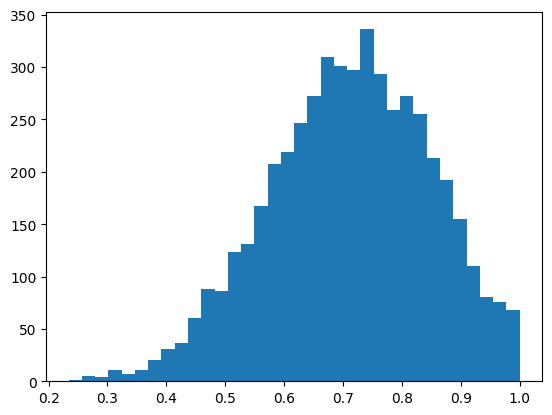

In [6]:
## define charging behavior 
charge_behave = 'dislike_fast_charge'
#'base' 'low_risk_sensitive' 'high_risk_sensitive' 
#'prefer_fast_charge' 'dislike_fast_charge' 

mean,sd, low, upp = Init_SOC(charge_behave)
# sample initial SOC for the EV list
SOC_int = get_truncated_normal(mean,sd, low, upp).rvs(size=len(EV_sample))
# draw sampled initial SOC
ax = plt.hist(SOC_int, bins='auto');
SOC_int = dict(zip(EV_sample, SOC_int))

In [7]:
print('number of EV',len(EV_sample))
print('number of trips',len(EV_trip))

number of EV 4944
number of trips 18666


In [8]:
###### _____________prepare geo data
# define zone name: the zone ID from geo data
zzones =  'SD10'#'SD10' 'OBJECTID'  'TRACT10' for others
Num_zone = len(shapefile[zzones].unique())
print('number of zones',Num_zone)

zone_array = np.sort(shapefile[zzones].unique()).tolist()
shapefile['new_zone_name'] = [zone_array.index(x)+1 for x in  shapefile[zzones]]

new_shape = shapefile[['new_zone_name', 'geometry']]
new_shape = new_shape.dissolve(by='new_zone_name', aggfunc='sum')
new_shape = new_shape.reset_index()

# change trip zone resolution
join_zones = pd.DataFrame(shapefile[['OBJECTID','new_zone_name']]).set_index('OBJECTID')
EV_trip = EV_trip.join(join_zones, on="d_taz")
EV_trip['d_taz']=EV_trip['new_zone_name']
EV_trip = EV_trip.drop(columns =['new_zone_name'])

number of zones 79


 ### call charging behavior functions

In [9]:
%run Charging_behavior_discrete_choice_function.ipynb

In [10]:
beta_SOC,beta_R,beta_delta_SOC,beta_0,beta_cost,beta_SOC_0,lbd = charging_behavior_parameter(charge_behave)

 ### call charging demand simulator

charging rate (kW) [home L2, non_home L2, non_home DCFC]: [  3.6   6.2 150. ]
home charging price ($): 0.13
simulation day: 2
* charging choice parameters:
beta_SOC: 3
beta_R: -0.005
beta_delta_SOC: 2
beta_0: 1
beta_SOC_0: 0.3
beta_cost: 0.1
lambda: 1
* charging choice plot parameters
not-home charging price ($): 0.43
available charging type (home, non-home L2, non_home DCFC): [0, 1, 1]
total energy of EV (kWh): 60


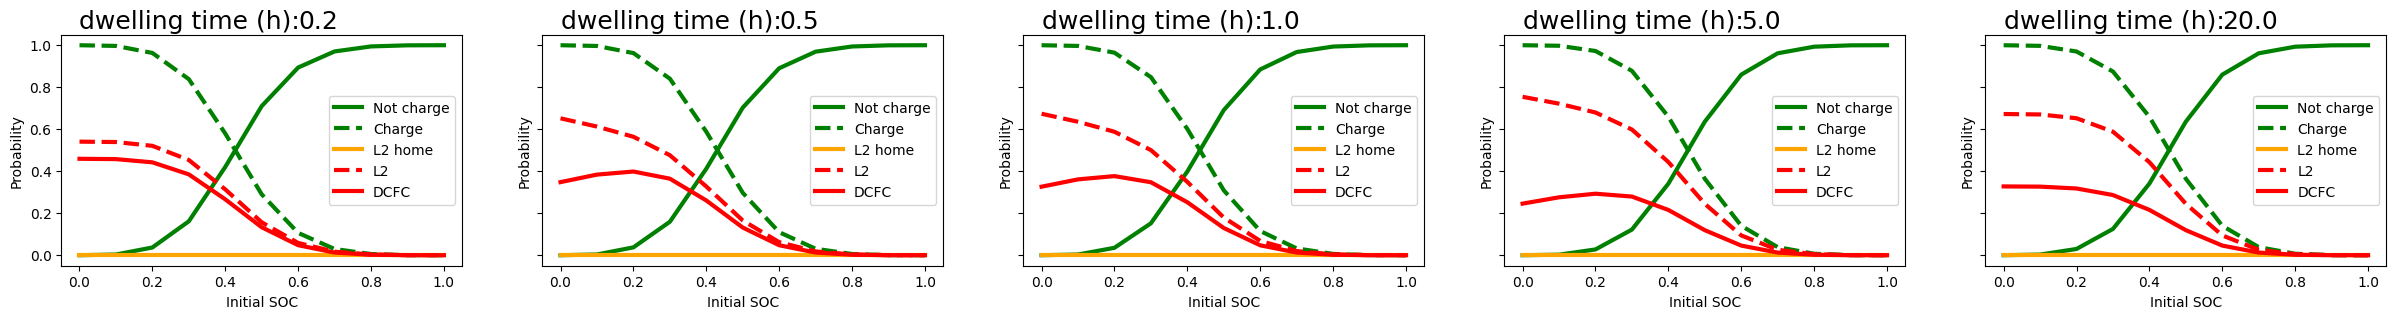

total energy of EV (kWh): 100


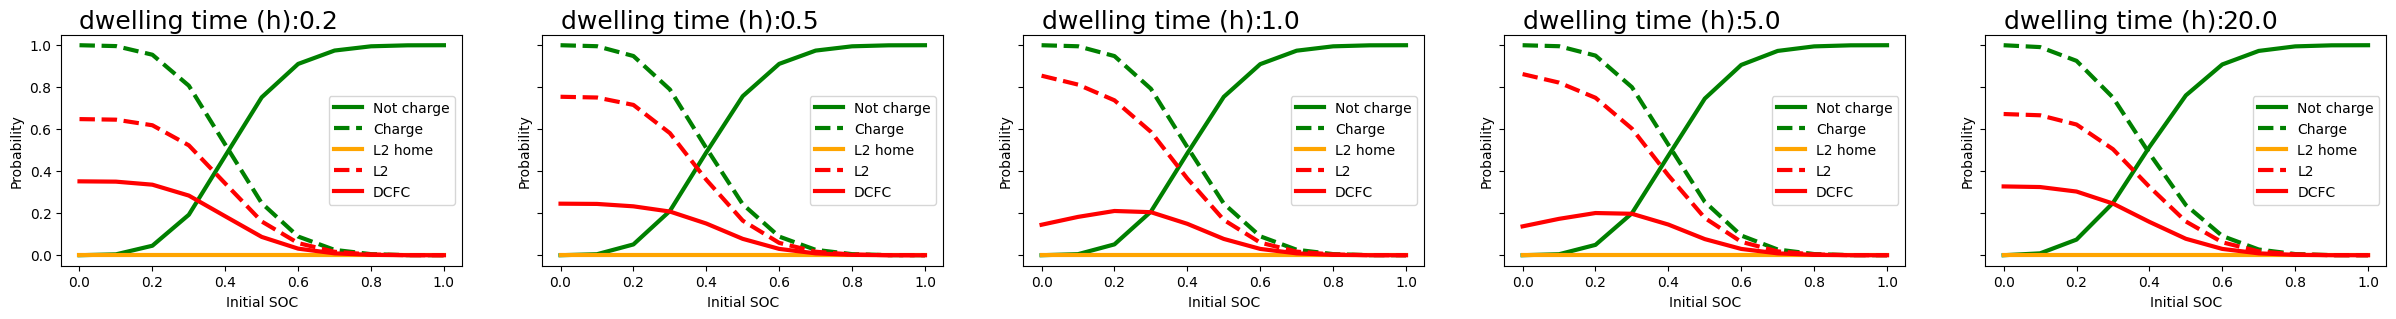

In [11]:
%run Charging_demand_simulation.ipynb

import os
import torch
ddtype = torch.double # need to make data format like this to avoid numerical errors

## define simulation input: charging number/taz

In [12]:
# define number of type i charger per zone, public charging price
dim = (2*Num_zone)  # dimension of variables
print("dimension of variables:",dim)


dimension of variables: 158


##  <span style='background :orange' > define public charging price

In [13]:
pub_price =  0.43 #1.2*home_price  # public charging price
print('public charging price $:',pub_price)

public charging price $: 0.43


##  <span style='background :orange' > define objective function variables

In [14]:
year = 10 # life-cycle time

discount_rate = 0.05 # discount rate

scale_to_year = 365

station_efficiency = 0.95 

electricity_cost = 0.11 # in $/kWh  U.S average 0.07 for industry; 0.11 for commercial

L2_buy_cost = 3450 # in $

DCFC_buy_cost =  25000   # in $

L2_build_cost =  3000   # in $

DCFC_build_cost = 21000   # in $

In [15]:
present_worth_factor = ((1 + discount_rate) ** year -1)/(discount_rate * (1 + discount_rate) ** year)
#print(present_worth_factor)

In [16]:
### define high dimension cost weight
invest_cost = [L2_buy_cost + L2_build_cost] * Num_zone
invest_cost.extend([DCFC_buy_cost + DCFC_build_cost] * Num_zone)
invest_cost = torch.tensor(invest_cost,dtype = ddtype)

##   define optimization function

In [17]:
##### define NPV 

def Optimization_function(inds):
    
    inds = torch.clamp(inds, min=0, max=None) # clamp negative values to 0
    
    average_daily_demand = daily_demand_BOTorch(inds)
    #print('average_daily_demand',average_daily_demand)
    
    year_revenue = scale_to_year * pub_price * average_daily_demand 
    #print('year_revenue',year_revenue)
    
    year_electricity_cost = scale_to_year * electricity_cost * average_daily_demand / station_efficiency
    #print('year_electricity_cost',year_electricity_cost)    
    #print(inds)    
    initial_invest_cost = sum((invest_cost*inds).t()).t()
    #print('initial_invest_cost',initial_invest_cost)
    
    year_m_o_cost = 0.1 * initial_invest_cost
    #print('year_m_o_cost',year_m_o_cost)
    
    year_benefit = year_revenue - year_electricity_cost - year_m_o_cost
    #print('year_benefit',year_benefit)
    
    NPV = present_worth_factor * year_benefit - initial_invest_cost
    return NPV

## Call solution solver

In [18]:
%run Solution_solvers.ipynb

##   define search box bounds

In [19]:
############# find number EV per zone per time
N_map = {} # define charge energy per TAZ

for i in shapefile['new_zone_name']:
    N_map[i] = {}
    #N_map[i]['max'] = 0
    for t in np.arange(0,48.1,0.5):
        N_map[i][round(t, 2)] = 0

for index, row in EV_trip.iterrows():
    d_purpose = row['d_purpose']
    if d_purpose != 'Home':
        tazz = row['d_taz']
        a_time = row['end_period']
        b_time = row['end_period'] + row['dwell_time']*2
        
        for t in np.arange(1,48.1,0.5):
            t = round(t, 2)
            if t == a_time:
                N_map[tazz][t] = N_map[tazz][t]+1

        for t in np.arange(1,48.1,0.5):
            t = round(t, 2)
            if t >= a_time and t <= b_time:
                N_map[tazz][t] = N_map[tazz][t]+1

In [20]:
########### max N. EV per zone at a time
# define a max number of station allowed to be at each location.
max_station_capacity = 5

max_EV_per_zone={}
for i in shapefile['new_zone_name']:
    max_EV_per_zone[i] =  round( 0.1 * max(N_map[i].values())) 
    if max_EV_per_zone[i] == 0:
        max_EV_per_zone[i] = max_EV_per_zone[i] + 0.1
    if max_EV_per_zone[i] >= max_station_capacity:
        max_EV_per_zone[i] = max_station_capacity
max_EV_per_zone.values()

dict_values([5, 5, 5, 5, 4, 5, 5, 4, 5, 5, 4, 2, 5, 5, 5, 2, 2, 3, 4, 4, 5, 3, 5, 5, 5, 5, 5, 4, 5, 5, 5, 4, 5, 2, 3, 2, 5, 3, 3, 5, 4, 4, 4, 3, 4, 1, 0.1, 5, 5, 5, 1, 0.1, 1, 2, 5, 4, 0.1, 1, 5, 0.1, 1, 0.1, 4, 1, 1, 0.1, 3, 2, 2, 4, 0.1, 1, 2, 2, 1, 1, 5, 3, 1])

In [21]:
## bounds for real x
x_real_u_bound = np.append(list(max_EV_per_zone.values()),list(max_EV_per_zone.values())) 
x_real_u_bound = torch.tensor(x_real_u_bound,dtype = ddtype)
x_real_l_bound = torch.tensor([0]*dim,dtype = ddtype)#torch.tensor([0.]*dim,dtype = ddtype)
x_real_bound = torch.tensor([x_real_l_bound.tolist(),x_real_u_bound],dtype = ddtype) 

# test run functions

In [22]:
##   test run the objective function value
test_value = []

test_v1 = [-1] * dim #np.append([1]*Num_zone,[1]*Num_zone)
test_value.append(test_v1)# add 0 list

test_v2 = [1] * dim #x_real_u_bound.tolist()
test_value.append(test_v2)

test_value = torch.FloatTensor(test_value).to(ddtype)
Optimization_function(test_value)

tensor([       0.0000, 10620426.4889], dtype=torch.float64)

##  <span style='background :orange' > define embedding dimension

In [23]:
### define embedding dimension
low_dim = 5

 ### embeded search space

In [24]:
# define embedding space searching box bounds
x_l_bound = -1
x_u_bound = 1

y_l_bound = -np.sqrt(low_dim)
y_u_bound = np.sqrt(low_dim)

# define y variance
y_variance = 0.1

In [25]:
## bounds for scaled x, and low dimension y, BO search bound (must be 0,1 for BOTorch)

x_scale_bound = (torch.tensor([[x_l_bound],[x_u_bound]])).repeat(1,dim).to(ddtype)

y_bound = (torch.tensor([[y_l_bound],[y_u_bound]])).repeat(1,low_dim).to(ddtype) 

#BO_bound = (torch.tensor([[0],[1]])).repeat(1,low_dim).to(ddtype)  # BOTorch search bound

##  <span style='background :Orange' > Define run parameters

In [26]:
# define how to run the simulation

N_initial = 2 # N. initial points, need to be >=2
BATCH_SIZE = 1 # N. new sample points  can't be over 1, takes too long to find optimize_acqf
N_BATCH = 5 # N. iteration each trial
N_TRIALS = 2 # N. try whole algorithm

##   test run BO

In [27]:
%run Solution_solvers.ipynb

In [28]:
## test generate points
gen = gen_high_dimension_variable(2)
gen

/var/folders/9h/jv2_h5p920q98ts_nn3wg9vh0000gp/T/ipykernel_25203/244477411.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  return torch.FloatTensor(rand_yy).to(ddtype)


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [3., 0., 1., 0., 3., 1., 3., 1., 4., 3., 2., 1., 4., 2., 2., 1., 0., 2.,
         1., 1., 4., 1., 4., 0., 3., 1., 1., 0., 0., 4., 2., 0., 2., 1., 1., 0.,
         3., 0., 1., 4., 0., 3., 3., 0., 1., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
         2., 1., 0., 0., 2., 0., 0., 0., 1.

In [29]:
# test generate_initial_data
import time

t0 = time.time()
init_x, init_y, best_init_y, best_init_x = generate_initial_data_BO(2)

t1 = time.time()

print('time', t1-t0)
print(init_y,init_x,best_init_y, best_init_x)

time 12.161381959915161
tensor([[      0.0000],
        [5235626.8567]], dtype=torch.float64) tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [4., 0., 1., 1., 3., 2., 4., 2., 4., 0., 0., 1., 2., 0., 0., 1., 1., 2.,
         2., 3., 1., 0., 3., 0., 2., 0., 0., 2., 1., 0., 2., 2., 0., 1., 1., 1.,
         2., 1., 1., 4., 2., 3

In [30]:
# test get_next_points

import time

t0 = time.time()

a = get_next_points_BO(init_x, init_y, best_init_y, x_real_bound, BATCH_SIZE)

t1 = time.time()

print(t1-t0)
print(a)

0.29019904136657715
tensor([[4., 0., 0., 2., 2., 4., 2., 3., 2., 0., 1., 1., 2., 2., 0., 0., 0., 2.,
         0., 3., 3., 0., 2., 0., 0., 1., 3., 1., 1., 3., 2., 0., 2., 0., 2., 1.,
         1., 2., 2., 4., 0., 2., 0., 1., 2., 0., 0., 1., 3., 1., 0., 0., 0., 0.,
         3., 2., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
         1., 0., 0., 0., 0., 1., 0., 3., 2., 4., 0., 1., 1., 1., 2., 2., 4., 1.,
         0., 3., 3., 0., 0., 1., 1., 2., 0., 0., 1., 0., 0., 3., 3., 1., 3., 3.,
         3., 1., 0., 1., 1., 2., 0., 2., 0., 0., 2., 2., 0., 2., 1., 2., 0., 0.,
         0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 3., 0., 0., 0., 1., 0., 0.,
         0., 2., 0., 1., 2., 0., 0., 0., 0., 0., 0., 4., 1., 0.]],
       dtype=torch.float64)


##   test run REMBO

In [31]:
## test generate points
A = gen_projection_rembo(low_dim,dim)
gen_low = gen_low_dimension_variable(1)
low_to_high_dimension(A,gen_low)

tensor([[2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 1., 1., 1.,
         2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1.,
         2., 1., 1., 2., 2., 2., 2., 1., 2., 0., 0., 2., 2., 2., 0., 0., 0., 1.,
         2., 2., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 1., 1., 1., 2., 0., 0.,
         1., 1., 0., 0., 2., 1., 0., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         1., 2., 2., 2., 1., 1., 1., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 1., 1., 1., 2., 1., 1., 2., 2., 2., 2., 1., 2., 0., 0.,
         2., 2., 2., 0., 0., 0., 1., 2., 2., 0., 0., 2., 0., 0., 0., 2., 0., 0.,
         0., 1., 1., 1., 2., 0., 0., 1., 1., 0., 0., 2., 1., 0.]],
       dtype=torch.float64)

In [32]:
# test generate_initial_data
import time

t0 = time.time()
A = gen_projection_rembo(low_dim,dim)
init_x, init_y, best_init_y, best_init_x = generate_initial_data_REMBO(A,2)

t1 = time.time()

print(t1-t0)

15.663102865219116


In [33]:
print(init_y,init_x,best_init_y, best_init_x)

tensor([[7557659.2158],
        [1224730.3943]], dtype=torch.float64) tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.7672,  1.2010, -2.1189,  0.3889, -0.5036]], dtype=torch.float64) 7557659.215819165 tensor([0., 0., 0., 0., 0.], dtype=torch.float64)


In [34]:
# test get_next_points

import time

t0 = time.time()

a = get_next_points_REMBO(init_x, init_y, best_init_y, y_bound, BATCH_SIZE)

t1 = time.time()

print(t1-t0)
print(a)

0.5169129371643066
tensor([[ 0.4609, -0.7215,  1.2728, -0.2336,  0.3026]], dtype=torch.float64)


##    Run results

In [35]:
import time

t0 = time.time()

Run_result = BO_run(N_initial,BATCH_SIZE,N_BATCH,N_TRIALS) 
#REMBO_run(N_initial,BATCH_SIZE,N_BATCH,N_TRIALS)
#BO_run(N_initial,BATCH_SIZE,N_BATCH,N_TRIALS) 
#Random_search(N_initial,BATCH_SIZE,N_BATCH,N_TRIALS) 

t1 = time.time()

print(t1-t0)


Trial  1 of 2 

.....
Trial  2 of 2 .....88.13706541061401


##    Show results

In [36]:
best_observed_all = Run_result[0]
best_observed_all_x = Run_result[1]
init_x = Run_result[2]
init_y = Run_result[3]

if len(Run_result) == 5:
    A_all = Run_result[4] ######### Active for REMBO

# plot results

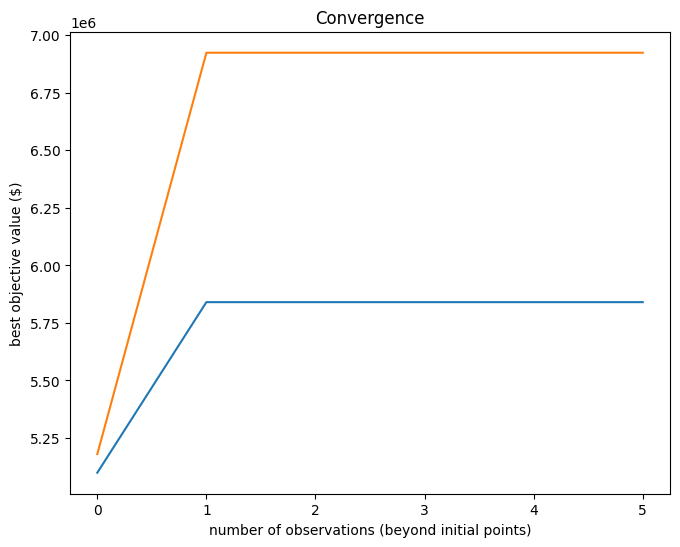

In [37]:
#####

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


iters = np.arange(len(best_observed_all_x[0])) 
y_value = np.asarray(best_observed_all)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for i in range(len(best_observed_all)):
    ax = plt.plot(iters, y_value[i])


plt.title('Convergence')
#plt.text(2, 0.65, r'$\cos(2 \pi t) \exp(-t)$')
plt.xlabel('number of observations (beyond initial points)')
plt.ylabel('best objective value ($)')

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
#plt.savefig('converge/%sconverge_iteration.png'%pr,bbox_inches='tight')


plt.show()

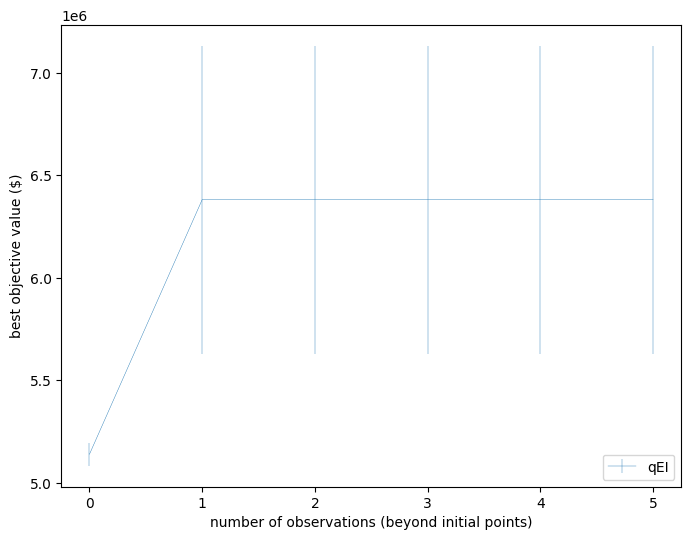

In [38]:
######### for REMBO 

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(len(best_observed_all))

iters = np.arange(len(best_observed_all_x[0]))
y_value = np.asarray(best_observed_all)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(iters, y_value.mean(axis=0), yerr=ci(y_value), label="qEI", linewidth=0.3)
#ax.set_ylim(bottom=5500000)
ax.set(xlabel='number of observations (beyond initial points)', ylabel='best objective value ($)')
ax.legend(loc="lower right")

In [39]:
new_shape = shapefile[['new_zone_name', 'geometry']]
new_shape = new_shape.dissolve(by='new_zone_name', aggfunc='sum')
new_shape = new_shape.reset_index()

### map best result

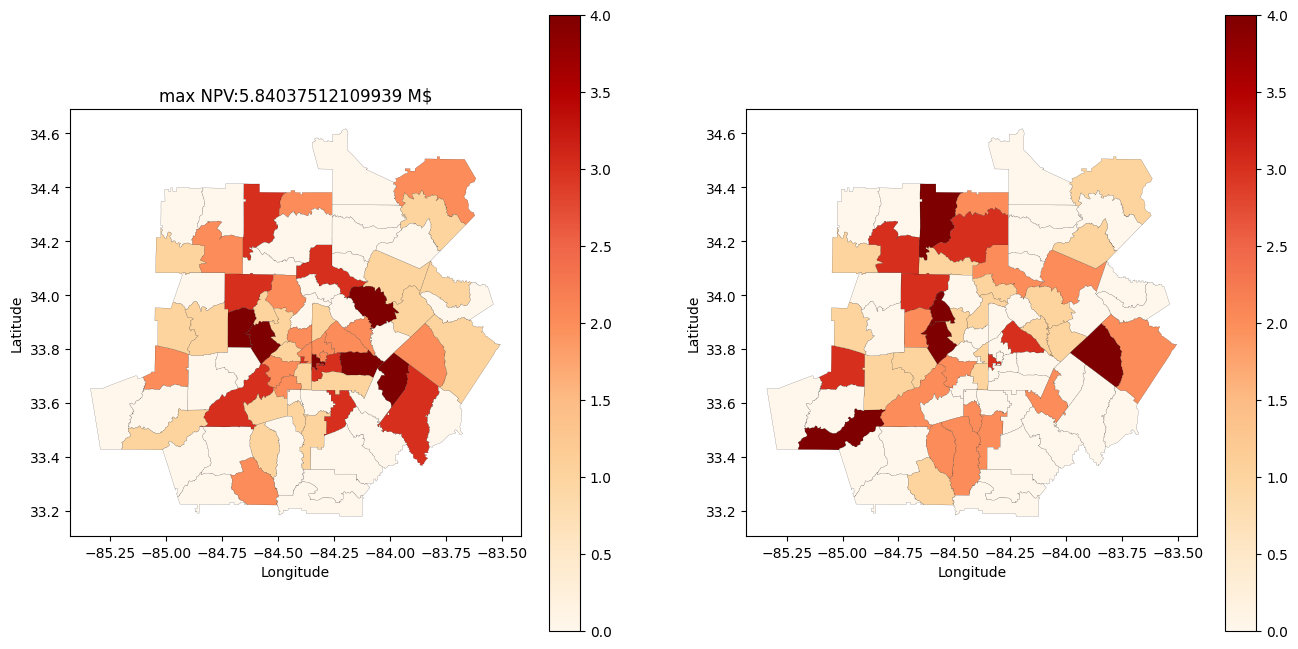

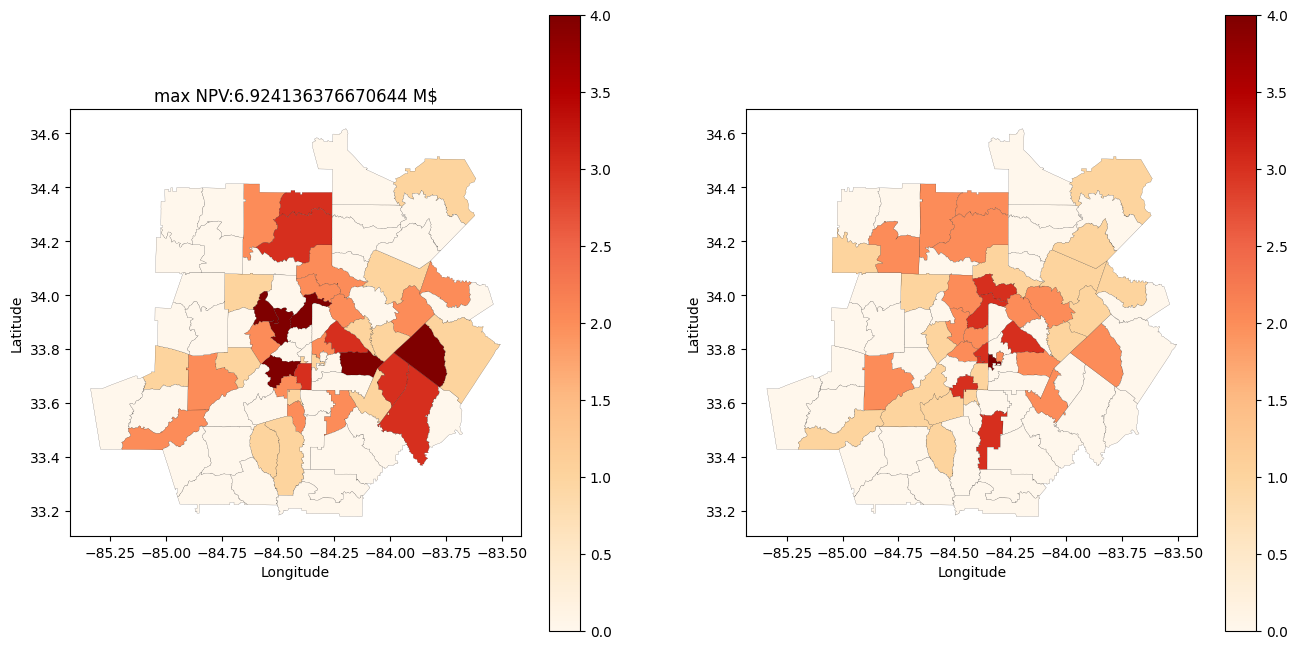

In [40]:
############# plot for BO (run only if used BO solver)


import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors


for i in range(len(best_observed_all)):
    which_trial = i # define which trail to plot
    result_x = best_observed_all_x[which_trial][N_BATCH]
    #result_x = low_to_high_dimension(A_all[i],result_x)
    result_x = torch.reshape(result_x,(2,Num_zone)).to(dtype = ddtype).tolist()
    max_NPV = max(best_observed_all[which_trial])

    new_shape['L2'] = result_x[0]
    new_shape['DCFC'] = result_x[1]
    new_shape[['L2','DCFC']] = new_shape[['L2','DCFC']].astype('float64')

    fig, ax = plt.subplots(1, 2,figsize=(16, 8))

    new_shape.plot(column='L2', ax=ax[0], legend=True,cmap='OrRd',edgecolor='black',linewidth = 0.1)


    new_shape.plot(column='DCFC', ax=ax[1], legend=True,cmap='OrRd',edgecolor='black',linewidth = 0.1)

    ax[0].set_ylabel('Latitude')
    ax[0].set_xlabel('Longitude')
    ax[0].set_title('max NPV:%s M$'%(max_NPV/10**6))
    ax[1].set_ylabel('Latitude')
    ax[1].set_xlabel('Longitude')

#plt.savefig('best_result.png',bbox_inches='tight');


In [41]:
############# plot for REMBO (run only if used REMBO solver)


import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors


for i in range(len(best_observed_all)):
    which_trial = i # define which trail to plot
    result_x = best_observed_all_x[which_trial][len(best_observed_all_x[0])-1]
    result_x = torch.clamp(low_to_high_dimension(A_all[i],result_x), min=0, max=None) 
    result_x = torch.reshape(result_x,(2,Num_zone)).to(dtype = ddtype).tolist()
    max_NPV = max(best_observed_all[which_trial])

    new_shape['L2'] = result_x[0]
    new_shape['DCFC'] = result_x[1]
    new_shape[['L2','DCFC']] = new_shape[['L2','DCFC']].astype('float64')

    fig, ax = plt.subplots(1, 2,figsize=(16, 8))

    new_shape.plot(column='L2', ax=ax[0], legend=True,cmap='Blues',edgecolor='black',linewidth = 0.1)


    new_shape.plot(column='DCFC', ax=ax[1], legend=True,cmap='Blues',edgecolor='black',linewidth = 0.1)

    ax[0].set_ylabel('Latitude')
    ax[0].set_xlabel('Longitude')
    ax[0].set_title('max NPV:%s M$'%(max_NPV/10**6))
    ax[1].set_title('N.l2:%s; N. DCFC:%s'%(sum(result_x[0]),sum(result_x[1])))
    ax[1].set_ylabel('Latitude')
    ax[1].set_xlabel('Longitude')

#plt.savefig('best_result.png',bbox_inches='tight');


NameError: name 'A_all' is not defined